## Logistic Regression

This notebook contains the logistic regression model we used to carry out classification.

In [66]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [67]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECO353')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Some Data Cleaning

In [68]:
df = pd.read_csv("prosperLoanData.csv")

In [69]:
category_mapping = {
    0: 'Not Available',
    1: 'Debt Consolidation',
    2: 'Home Improvement',
    3: 'Business',
    4: 'Personal Loan',
    5: 'Student Use',
    6: 'Auto',
    7: 'Other',
    8: 'Baby&Adoption',
    9: 'Boat',
    10: 'Cosmetic Procedure',
    11: 'Engagement Ring',
    12: 'Green Loans',
    13: 'Household Expenses',
    14: 'Large Purchases',
    15: 'Medical/Dental',
    16: 'Motorcycle',
    17: 'RV',
    18: 'Taxes',
    19: 'Vacation',
    20: 'Wedding Loans'
}

df['ListingCategory'] = df['ListingCategory (numeric)'].map(category_mapping)

In [71]:
df_filtered = df[["LoanStatus", "CreditGrade", "BorrowerRate", "ProsperScore",
                  "ListingCategory","Occupation","EmploymentStatus",
                  "IsBorrowerHomeowner", "IncomeVerifiable", "IncomeRange",
                  "LoanOriginalAmount", "Recommendations", "PercentFunded",
                  "CurrentDelinquencies" , "InquiriesLast6Months",
                  "PublicRecordsLast10Years"]] #"BorrowerState"
df_filtered = df_filtered[df_filtered['LoanStatus'].isin(['Completed', 'Defaulted'])]
df_filtered['Default'] = np.where(df_filtered['LoanStatus'] == 'Completed', 0, 1)

# Compute the percentage of missing values in the dataset.
count = df_filtered.isnull().sum()
percent = (df_filtered.isnull().sum()/43092)
missing_data = pd.concat([count, percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_data.head(100)

,missing_count,missing_percent
LoanStatus,0,0.000000
CreditGrade,20794,0.482549
BorrowerRate,0,0.000000
ProsperScore,22423,0.520352
ListingCategory,0,0.000000
Occupation,1974,0.045809
EmploymentStatus,1961,0.045507
IsBorrowerHomeowner,0,0.000000
IncomeVerifiable,0,0.000000
IncomeRange,0,0.000000


CreditGrade: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings;

ProsperScore: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009.

In [72]:
# Creidt grade - omitted: NC
df_filtered['creditgrade_AA'] = np.where(df_filtered['CreditGrade'] == 'AA', 1, 0)
df_filtered['creditgrade_A'] = np.where(df_filtered['CreditGrade'] == 'A', 1, 0)
df_filtered['creditgrade_B'] = np.where(df_filtered['CreditGrade'] == 'B', 1, 0)
df_filtered['creditgrade_C'] = np.where(df_filtered['CreditGrade'] == 'C', 1, 0)
df_filtered['creditgrade_D'] = np.where(df_filtered['CreditGrade'] == 'D', 1, 0)
df_filtered['creditgrade_E'] = np.where(df_filtered['CreditGrade'] == 'E', 1, 0)
df_filtered['creditgrade_HR'] = np.where(df_filtered['CreditGrade'] == 'HR', 1, 0)

# Income range - omitted: Not displayed
df_filtered['no_income'] = np.where(df_filtered['IncomeRange'].isin(['$0', 'Not employed']), 1, 0)
df_filtered['income_below25k'] = np.where(df_filtered['IncomeRange'] == '$1-24,999', 1, 0)
df_filtered['income_25k_50k'] = np.where(df_filtered['IncomeRange'] == '$25,000-49,999', 1, 0)
df_filtered['income_50k_75k'] = np.where(df_filtered['IncomeRange'] == '$50,000-74,999', 1, 0)
df_filtered['income_75k_100k'] = np.where(df_filtered['IncomeRange'] == '$75,000-99,999', 1, 0)
df_filtered['income_greater100k'] = np.where(df_filtered['IncomeRange'] == '$100,000+', 1, 0)

# Homeowner - ommited: No
df_filtered['is_homeowner'] = np.where(df_filtered['IsBorrowerHomeowner'] == 'True', 1, 0)

# Income verifiable - omitted: No
df_filtered['income_verifiable'] = np.where(df_filtered['IncomeVerifiable'] == 'True', 1, 0)

In [73]:
# Create the dummy for students
students = ['Student - College Senior', 'Student - College Graduate Student',
                       'Student - Technical School', 'Student - College Junior',
                       'Student - Community College', 'Student - College Freshman',
                       'Student - College Sophomore']

df_filtered['is_student'] = np.where(df_filtered['Occupation'].isin(students), 1, 0)

In [74]:
# Re-categorize the employment status
def categorize_employment(status):
    if status in ['Employed', 'Full-time', 'Part-time', 'Self-employed']:
        return 'Yes'
    elif status in ['Not employed', 'Retired']:
        return 'No'
    else:
        return 'Not Available or Others'

df_filtered['Employment'] = df_filtered['EmploymentStatus'].apply(categorize_employment)

# Employment status - omitted: Not Available or Others
df_filtered['employment_yes'] = np.where(df_filtered['Employment'] == 'True', 1, 0)
df_filtered['employment_no'] = np.where(df_filtered['Employment'] == 'No', 1, 0)

In [75]:
# Re-categorize the listing category status
def categorize_listing(category):
    if category in ['Not Available']:
        return 'No'
    else:
        return 'Yes'

df_filtered['ReportedLoanPurpose'] = df_filtered['ListingCategory'].apply(categorize_listing)

# Reported purpose - omitted: No (NOT reported)
df_filtered['reported_purpose'] = np.where(df_filtered['ReportedLoanPurpose'] == 'Yes', 1, 0)

In [76]:
# Drop original, uncleaned columns
df_filtered = df_filtered.drop(columns = ['LoanStatus', 'CreditGrade', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'Employment', 'ListingCategory', 'IncomeRange', 'IncomeVerifiable', 'ReportedLoanPurpose'])

## Missing data imputation

In [77]:
# Normalize data before KNN imputation - otherwise the difference in scales of each prediction may lead to biased imputed values
scaler = MinMaxScaler()
df_filtered = pd.DataFrame(scaler.fit_transform(df_filtered), columns = df_filtered.columns)

# KNN imputation - fill in each missing value by using values of its 5 nearest neighbors (with smallest euclidean distances), uniformly weighted
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(df_filtered.drop(columns=['Default']))

# Convert the imputed array back to a dataframe, since the state and year dummies will be added later
X_imputed_df = pd.DataFrame(X_imputed, columns=df_filtered.drop(columns=['Default']).columns)

In [78]:
# Add dummies for fixed effects
df = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]
df["Year"] = pd.to_datetime(df['ListingCreationDate'], format = 'mixed').dt.year
temp = df[["Year", "BorrowerState"]]
temp = temp.reset_index(drop=True)

X_imputed_df = pd.concat([X_imputed_df, temp], axis=1)
X_imputed_df["BorrowerState"].fillna("Unknown", inplace=True)

year_dummies = pd.get_dummies(X_imputed_df["Year"], prefix="Year", drop_first=True)
state_dummies = pd.get_dummies(X_imputed_df["BorrowerState"], prefix="State", drop_first=True)
X_imputed_df = pd.concat([X_imputed_df, year_dummies, state_dummies], axis=1)
X_imputed_df.drop(columns=['Year', 'BorrowerState'], inplace=True)
X_imputed_df

<ipython-input-78-bb31209eb817>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = pd.to_datetime(df['ListingCreationDate'], format = 'mixed').dt.year


,BorrowerRate,ProsperScore,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years,creditgrade_AA,creditgrade_A,creditgrade_B,creditgrade_C,creditgrade_D,creditgrade_E,creditgrade_HR,no_income,income_below25k,income_25k_50k,income_50k_75k,income_75k_100k,income_greater100k,is_homeowner,income_verifiable,is_student,employment_yes,employment_no,reported_purpose,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_Unknown,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.317588,0.52,0.247794,0.000000,0.96463,0.024096,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.552764,0.50,0.058853,0.000000,0.96463,0.012048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0.266332,0.60,0.000000,0.000000,0.96463,0.036145,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,0.638593,0.40,0.088235,0.000000,0.96463,0.000000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0.417085,0.58,0.058824,0.000000,0.96463,0.012048,0.000000,0.045455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.582915,0.50,0.058824,0.000000,0.96463,0.216867,0.031746,0.318182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Fal

## Split data into training and testing sets

In [79]:
# Separate features and target variables
X = X_imputed_df
y = df_filtered['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1006693712)

## Variable Selection by Stepwise AIC

In [40]:
# Note: This chunk takes around 10 mins to run. To save time, skip this chunk.
model_logistic = LogisticRegression(max_iter=1000, penalty=None)

# Stepwise feature selection
stepwise_selection = SequentialFeatureSelector(model_logistic, n_features_to_select=15, direction='forward', cv=5)
stepwise_selection.fit(X_train, y_train)

# Print the selected features
stepwise_features = X.columns[stepwise_selection.get_support(indices=True)]
print("Features determined by forward stepwise selection:", stepwise_features)

KeyboardInterrupt: 

## Default Logistic Model fitting

In [80]:
# Run this chunk instead the last chunk to save time
# Note that the default sklearn.LogisticRegression uses L2 penalty to avoid overfitting
model_logistic = LogisticRegression(max_iter=1000) # , penalty = None
stepwise_features = ['BorrowerRate', 'ProsperScore', 'CurrentDelinquencies',
       'InquiriesLast6Months', 'creditgrade_AA', 'creditgrade_HR',
       'income_75k_100k', 'reported_purpose', 'Year_2006', 'State_ID',
       'State_MA', 'State_MI', 'State_NC', 'State_NY', 'State_Unknown']

In [81]:
# Keep predictor variables selected by the stepwise selection
X_stepwise = X[stepwise_features]

# Split the data into training and testing sets
X_stepwise_train, X_stepwise_test, y_stepwise_train, y_stepwise_test = train_test_split(X_stepwise, y, test_size=0.25, random_state=1006693712)

# Fit a logistic regression using features selected by forward stepwise selection
model_logistic.fit(X_stepwise_train, y_stepwise_train)

# Predict on the test set
y_stepwise_pred = model_logistic.predict(X_stepwise_test)

# Calculate the accuracy score
accuracy_stepwise = accuracy_score(y_stepwise_test, y_stepwise_pred)
print("The prediction accuracy by the logistic regression model with predictors selected by stepwise selection:", accuracy_stepwise)

The prediction accuracy by the logistic regression model with predictors selected by stepwise selection: 0.9002134967047247


In [82]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_stepwise_test, y_stepwise_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9513   77]
 [ 998  185]]


### Re-fit using statsmodel to get summary table

In [128]:
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit

X_stepwise_train_sm = sm.add_constant(X_stepwise_train)  # adding a constant for the intercept

# Convert some columns from boolean to float
X_stepwise_train_sm = X_stepwise_train_sm.apply(lambda x: x.astype(int) if x.dtype == bool else x)

stats_logistic_model = sm.GLM(y_stepwise_train, X_stepwise_train_sm,
                               family=Binomial(link=Logit()))
result = stats_logistic_model.fit_regularized(L1_wt=0)
print(result)

ValueError: The indices for endog and exog are not aligned

In [99]:
result.summary()

NotImplementedError: 

In [90]:
print(stats_logistic_model.params)

const                  -0.800165
BorrowerRate           -0.161850
ProsperScore           -0.539652
CurrentDelinquencies    0.023134
InquiriesLast6Months    0.023278
creditgrade_AA         -0.133924
creditgrade_HR          0.163476
income_75k_100k        -0.130235
reported_purpose       -0.748720
Year_2006               0.095747
State_ID               -0.001342
State_MA               -0.026625
State_MI               -0.015214
State_NC               -0.034957
State_NY               -0.070141
State_Unknown          -0.172643
dtype: float64


In [83]:
import statsmodels.api as sm

X_stepwise_train_sm = sm.add_constant(X_stepwise_train)  # adding a constant for the intercept

# Convert some columns from boolean to float
X_stepwise_train_sm = X_stepwise_train_sm.apply(lambda x: x.astype(int) if x.dtype == bool else x)

model = sm.Logit(y_stepwise_train, X_stepwise_train_sm)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.308536
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                32319
Model:                          Logit   Df Residuals:                    32303
Method:                           MLE   Df Model:                           15
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                  0.1530
Time:                        18:24:12   Log-Likelihood:                -9971.6
converged:                       True   LL-Null:                       -11772.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.9196      0.145    -20.145      0.000      -3.204      -2.636

In [38]:
# Compare with model fitted by sklearn. Difference acceptable.
print(model_logistic.intercept_)
print(model_logistic.coef_)

[-2.7844995]
[[ 2.9976198   0.20806507  4.306948    5.21778387 -0.18142451  0.43042531
  -0.1876854  -1.30267627  0.58632254  0.03107003 -0.45479622 -0.0347929
  -0.3721385  -0.50408394 -1.201993  ]]


In [39]:
scaler.scale_

array([2.01005025e+00, 1.00000000e-01, 2.94117647e-05, 2.56410256e-02,
       3.21543408e+00, 1.20481928e-02, 1.58730159e-02, 4.54545455e-02,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

## Attach payoff variables

In [108]:
additional_df1 = df_filtered[["LoanOriginalAmount","Default"]]
# get some additional variables and center them
additional_df2 = df[(df["LoanStatus"] == "Completed") | (df["LoanStatus"] == "Defaulted")]
additional_df2 = additional_df2.reset_index(drop=True)
additional_df2 = additional_df2[["LoanOriginalAmount", "BorrowerRate", "LP_InterestandFees", "LP_GrossPrincipalLoss"]]
additional_df2 = additional_df2.rename(columns={'LoanOriginalAmount': 'RealLoanOriginalAmount', 'BorrowerRate': 'RealBorrowerRate'})
#scaler = MinMaxScaler()
#additional_df = pd.DataFrame(scaler.fit_transform(additional_df), columns = additional_df.columns)
# Sort the index of training set
X_stepwise_train = X_stepwise_train.sort_index()
training_df = pd.merge(left = X_stepwise_train, right = additional_df1, how = 'left', left_index=True, right_index=True)
training_df = pd.merge(left = training_df, right = additional_df2, how = 'left', left_index=True, right_index=True)
training_df

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss
0,0.317588,0.52,0.024096,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.247794,0.0,9425,0.1580,1971.14,0.00
1,0.552764,0.50,0.012048,0.000000,0.0,1.0,0.0,0.0,False,False,False,False,False,False,False,0.058853,0.0,3001,0.2750,1185.63,0.00
2,0.266332,0.60,0.036145,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1325,11.65,0.00
3,0.638593,0.40,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.088235,1.0,4000,0.3177,311.38,3790.25
4,0.417085,0.58,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,0.058824,0.0,3000,0.2075,1061.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43086,0.419899,0.54,0.000000,0.015873,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.205882,0.0,8000,0.2089,2830.40,0.00
43087,0.582915,0.50,0.216867,0.031746,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.058824,1.0,3000,0.2900,541.86,2536.11
43088,0.136482,0.88,0.000000,0.015873,1.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.096824,0.0,4292,0.0679,464.93,0.00
43089,0.381709,0.50,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.029412,0.0,2000,0.1899,83.62,0.00


In [109]:
# Generate variables for payoffs
training_df['payoff_TN'] = training_df["RealLoanOriginalAmount"]*(training_df["RealBorrowerRate"])
training_df['payoff_FN'] = -(training_df["LP_GrossPrincipalLoss"] + \
 (training_df["RealLoanOriginalAmount"]*(training_df["RealBorrowerRate"]) - \
  training_df["LP_InterestandFees"]))
training_df['payoff_FP'] = 0
training_df['payoff_TP'] = 0
training_df

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss,payoff_TN,payoff_FN,payoff_FP,payoff_TP
0,0.317588,0.52,0.024096,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.247794,0.0,9425,0.1580,1971.14,0.00,1489.1500,481.9900,0,0
1,0.552764,0.50,0.012048,0.000000,0.0,1.0,0.0,0.0,False,False,False,False,False,False,False,0.058853,0.0,3001,0.2750,1185.63,0.00,825.2750,360.3550,0,0
2,0.266332,0.60,0.036145,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1325,11.65,0.00,132.5000,-120.8500,0,0
3,0.638593,0.40,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.088235,1.0,4000,0.3177,311.38,3790.25,1270.8000,-4749.6700,0,0
4,0.417085,0.58,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,0.058824,0.0,3000,0.2075,1061.05,0.00,622.5000,438.5500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43086,0.419899,0.54,0.000000,0.015873,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.205882,0.0,8000,0.2089,2830.40,0.00,1671.2000,1159.2000,0,0
43087,0.582915,0.50,0.216867,0.031746,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.058824,1.0,3000,0.2900,541.86,2536.11,870.0000,-2864.2500,0,0
43088,0.136482,0.88,0.000000,0.015873,1.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.096824,0.0,4292,0.0679,464.93,0.00,291.4268,173.5032,0,0
43089,0.381709,0.50,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.029412,0.0,2000,0.1899,83.62,0.00,379.8000,-296.1800,0,0


In [122]:
# Obtain testing df with additional variables
X_stepwise_test = X_stepwise_test.sort_index()
testing_df = pd.merge(left = X_stepwise_test, right = additional_df1, how = 'left', left_index=True, right_index=True)
testing_df = pd.merge(left = testing_df, right = additional_df2, how = 'left', left_index=True, right_index=True)
# Generate variables for payoffs
testing_df['payoff_TN'] = testing_df["RealLoanOriginalAmount"]*(testing_df["RealBorrowerRate"])
testing_df['payoff_FN'] = -(testing_df["LP_GrossPrincipalLoss"] + \
 (testing_df["RealLoanOriginalAmount"]*(testing_df["RealBorrowerRate"]) - \
  testing_df["LP_InterestandFees"]))
testing_df['payoff_FP'] = 0
testing_df['payoff_TP'] = 0
testing_df
#testing_df[testing_df['Default'] == 1]

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss,payoff_TN,payoff_FN,payoff_FP,payoff_TP
6,0.564623,0.20,0.000000,0.031746,0.0,0.0,0.0,1.0,False,False,False,False,False,True,False,0.088235,0.0,4000,0.2809,725.35,0.0,1123.60,-398.25,0,0
8,0.200804,0.80,0.012048,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.264706,0.0,10000,0.0999,686.32,0.0,999.00,-312.68,0,0
12,0.321608,0.52,0.000000,0.031746,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.176471,0.0,7000,0.1600,1861.43,0.0,1120.00,741.43,0,0
16,0.395980,0.66,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1970,294.98,0.0,197.00,97.98,0,0
18,0.502513,0.56,0.036145,0.000000,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.035294,0.0,2200,0.2500,511.61,0.0,550.00,-38.39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43075,0.278392,0.70,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.102941,0.0,4500,0.1385,1024.18,0.0,623.25,400.93,0,0
43082,0.402010,0.48,0.012048,0.079365,0.0,0.0,0.0,1.0,False,False,True,False,False,False,False,0.058824,0.0,3000,0.2000,1064.13,0.0,600.00,464.13,0,0
43084,0.080402,0.60,0.002410,0.003175,1.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.0400,0.89,0.0,40.00,-39.11,0,0
43085,0.260302,0.76,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.117647,0.0,5000,0.1295,1061.29,0.0,647.50,413.79,0,0


In [127]:
# Calculate expected payoff for the default logistic model
actual = testing_df["Default"]
N = len(testing_df)
predicted_test_logistic_default = y_stepwise_pred
# Calculate expected payoff
TP = (predicted_test_logistic_default == 1) & (actual == 1)
TN = (predicted_test_logistic_default == 0) & (actual == 0)
FP = (predicted_test_logistic_default == 1) & (actual == 0)
FN = (predicted_test_logistic_default == 0) & (actual == 1)
payoff_logistic_default = np.sum(testing_df['payoff_TP'][TP]) + \
     np.sum(testing_df['payoff_TN'][TN]) + \
     np.sum(testing_df['payoff_FP'][FP]) + \
     np.sum(testing_df['payoff_FN'][FN])


print(f"Optimal Payoff: {payoff_logistic_default/N}")

Optimal Payoff: 405.52825746774363


## Tuning Logistic Model to Maximize Payoff

In [111]:
# Prediction
probabilities = model_logistic.predict_proba(X_stepwise_train)[:, 1]  # Get the probability of the positive class

(array([2.0479e+04, 7.4730e+03, 2.0270e+03, 8.8500e+02, 6.0000e+02,
        3.8800e+02, 2.6400e+02, 1.4500e+02, 4.1000e+01, 1.7000e+01]),
 array([0.0063733 , 0.10529864, 0.20422399, 0.30314933, 0.40207467,
        0.50100002, 0.59992536, 0.69885071, 0.79777605, 0.8967014 ,
        0.99562674]),
 <BarContainer object of 10 artists>)

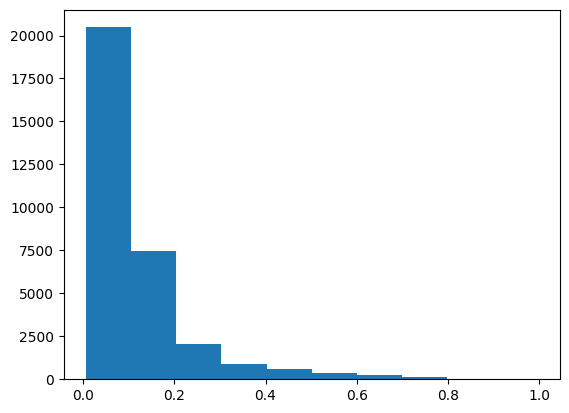

In [112]:
# Check the distribution of predicted probabilities.
plt.hist(probabilities)

In [121]:
# Find optimal threshold for logistic regression
N = len(training_df)
thresholds = np.linspace(0, 1, 101)  # Define a range of possible thresholds
optimal_payoff = -np.inf
optimal_threshold = None
actual = training_df["Default"]

for threshold in thresholds:
    # Vectorized calculation of classifications based on the current threshold
    predictions = (probabilities > threshold).astype(float)

    # Vectorized calculation of payoffs
    TP = (predictions == 1) & (actual == 1)
    TN = (predictions == 0) & (actual == 0)
    FP = (predictions == 1) & (actual == 0)
    FN = (predictions == 0) & (actual == 1)

    # Calculate total expected payoff for the current threshold
    current_payoff = np.sum(training_df['payoff_TP'][TP]) + \
     np.sum(training_df['payoff_TN'][TN]) + \
     np.sum(training_df['payoff_FP'][FP]) + \
     np.sum(training_df['payoff_FN'][FN])

    # Update optimal threshold if the current threshold yields a higher payoff
    if current_payoff > optimal_payoff:
        optimal_payoff = current_payoff
        optimal_threshold = threshold

print(f"Optimal Threshold: {optimal_threshold}, Optimal Payoff: {optimal_payoff/N}")

Optimal Threshold: 0.21, Optimal Payoff: 514.4084135338346


In [116]:
optimal_threshold

0.21

In [117]:
# Prediction to the testing set
probabilities_test = model_logistic.predict_proba(X_stepwise_test)[:, 1]  # Get the probability of the positive class
# Use the threshold from training set to carry out classification
predicted_test_logistic = (probabilities_test > optimal_threshold).astype(int)

In [123]:
accuracy_logistic = accuracy_score(y_stepwise_test, predicted_test_logistic)
accuracy_logistic

0.792722547108512

In [119]:
predicted_test_logistic.sum()

1348

In [124]:
actual = testing_df["Default"]
N = len(testing_df)

# Vectorized calculation of payoffs
TP = (predicted_test_logistic == 1) & (actual == 1)
TN = (predicted_test_logistic == 0) & (actual == 0)
FP = (predicted_test_logistic == 1) & (actual == 0)
FN = (predicted_test_logistic == 0) & (actual == 1)

# Calculate total expected payoff for the current threshold
payoff_logistic = (np.sum(testing_df['payoff_TP'][TP]) + \
  np.sum(testing_df['payoff_TN'][TN]) + \
  np.sum(testing_df['payoff_FP'][FP]) + \
  np.sum(testing_df['payoff_FN'][FN]))/N
payoff_logistic

541.7369068226122

(array([6.869e+03, 2.458e+03, 6.770e+02, 2.970e+02, 1.880e+02, 1.300e+02,
        8.400e+01, 4.500e+01, 1.900e+01, 6.000e+00]),
 array([0.01035599, 0.10574293, 0.20112987, 0.29651681, 0.39190374,
        0.48729068, 0.58267762, 0.67806456, 0.77345149, 0.86883843,
        0.96422537]),
 <BarContainer object of 10 artists>)

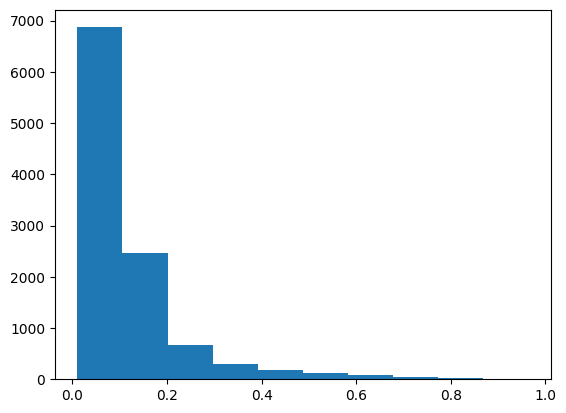

In [125]:
plt.hist(probabilities_test)